In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/MPI_11.csv")


In [12]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["gridRows"] = dataFrame["gridRows"].astype(int)
dataFrame["gridCols"] = dataFrame["gridCols"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["medianTimeSeconds"] = dataFrame["medianTimeSeconds"].astype(float)
dataFrame["globalSum"] = dataFrame["globalSum"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)
dataFrame["commType"] = dataFrame["commType"].astype(str)

print("Loaded rows:", len(dataFrame))
print("Comm types:", dataFrame["commType"].unique())
print("Grid shapes:", sorted(dataFrame[["gridRows","gridCols"]].drop_duplicates().values.tolist()))
print("Process counts:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(8)


Loaded rows: 162
Comm types: ['world' 'row' 'col']
Grid shapes: [[1, 1], [1, 2], [2, 2], [2, 3], [2, 4], [3, 3], [4, 4], [4, 8], [8, 8]]
Process counts: [1, 2, 4, 6, 8, 9, 16, 32, 64]


,testType,gridRows,gridCols,numProcesses,commType,medianTimeSeconds,globalSum,runIndex,mpiEnv
0,MPI_11,1,1,1,world,0.0,1.0,1,PROCS=1
1,MPI_11,1,1,1,row,0.0,1.0,1,PROCS=1
2,MPI_11,1,1,1,col,0.0,1.0,1,PROCS=1
3,MPI_11,1,1,1,world,0.0,1.0,2,PROCS=1
4,MPI_11,1,1,1,row,0.0,1.0,2,PROCS=1
5,MPI_11,1,1,1,col,0.0,1.0,2,PROCS=1
6,MPI_11,1,1,1,world,0.0,1.0,3,PROCS=1
7,MPI_11,1,1,1,row,0.0,1.0,3,PROCS=1


In [13]:
groupedFrame = dataFrame.groupby(["commType","gridRows","gridCols","numProcesses"], as_index=False).agg(
    median=("medianTimeSeconds","median"),
    mean=("medianTimeSeconds","mean"),
    std=("medianTimeSeconds","std"),
    count=("medianTimeSeconds","count")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["commType","gridRows","gridCols","numProcesses"]).reset_index(drop=True)
groupedFrame.head(12)


,commType,gridRows,gridCols,numProcesses,median,mean,std,count
0,col,1,1,1,0.000000,0.000000,0.000000,6
1,col,1,2,2,0.000000,0.000000,0.000000,6
2,col,2,2,4,0.000000,0.000000,0.000000,6
3,col,2,3,6,0.000000,0.000000,0.000000,6
4,col,2,4,8,0.000000,0.000000,0.000000,6
5,col,3,3,9,0.000001,0.000001,0.000000,6
6,col,4,4,16,0.000001,0.000001,0.000000,6
7,col,4,8,32,0.000001,0.000001,0.000000,6
8,col,8,8,64,0.021286,0.022615,0.002769,6
9,row,1,1,1,0.000000,0.000000,0.000000,6


In [14]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    for (gridRowsVal, gridColsVal, numProcessesVal), sub in groupedDf.groupby(["gridRows","gridCols","numProcesses"]):
        baseRows = sub[sub["commType"] == "world"]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        if not np.isfinite(baseTime) or baseTime <= 0.0:
            continue
        subFrame = sub.copy()
        with np.errstate(divide='ignore', invalid='ignore'):
            subFrame["speedup"] = baseTime / subFrame["median"]
            subFrame.loc[~np.isfinite(subFrame["speedup"]), "speedup"] = np.nan
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numProcesses"]
        subFrame.loc[~np.isfinite(subFrame["efficiency"]), "efficiency"] = np.nan
        frames.append(subFrame)
    if not frames:
        return pd.DataFrame(columns=groupedDf.columns.tolist() + ["speedup","efficiency"])
    perfFrame = pd.concat(frames, ignore_index=True)

    perfFrame.replace([np.inf, -np.inf], np.nan, inplace=True)
    return perfFrame

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)


,commType,gridRows,gridCols,numProcesses,median,mean,std,count,speedup,efficiency
0,col,2,2,4,0.000000e+00,0.000000e+00,0.000000e+00,6,NaN,NaN
1,row,2,2,4,0.000000e+00,0.000000e+00,0.000000e+00,6,NaN,NaN
2,world,2,2,4,5.000000e-07,5.000000e-07,5.477226e-07,6,1.0,0.250000
3,col,2,3,6,0.000000e+00,0.000000e+00,0.000000e+00,6,NaN,NaN
4,row,2,3,6,1.000000e-06,1.000000e-06,0.000000e+00,6,1.0,0.166667
5,world,2,3,6,1.000000e-06,1.000000e-06,0.000000e+00,6,1.0,0.166667
6,col,2,4,8,0.000000e+00,0.000000e+00,0.000000e+00,6,NaN,NaN
7,row,2,4,8,1.000000e-06,1.000000e-06,0.000000e+00,6,1.0,0.125000
8,world,2,4,8,1.000000e-06,1.000000e-06,0.000000e+00,6,1.0,0.125000
9,col,3,3,9,1.000000e-06,1.000000e-06,0.000000e+00,6,1.0,0.111111


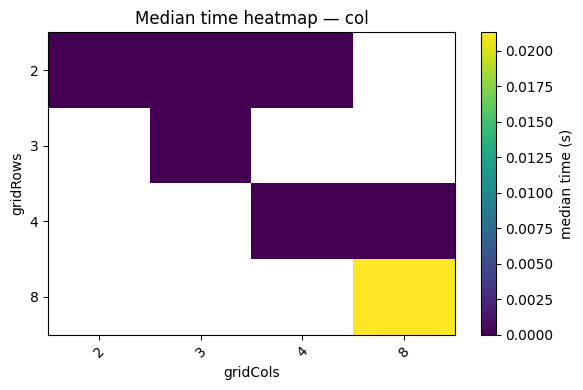

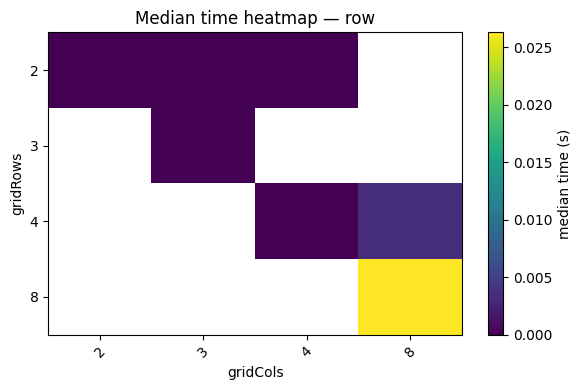

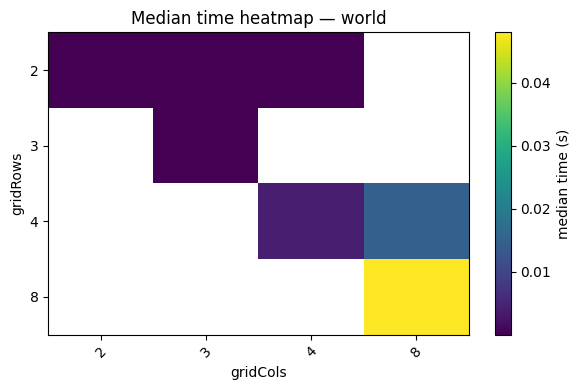

In [15]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["median","speedup","efficiency"]
metricLabels = {"median":"Median Time (s)", "speedup":"Speedup", "efficiency":"Efficiency"}

commTypes = sorted(perfFrame["commType"].unique())
numProcessesList = sorted(perfFrame["numProcesses"].unique())

for commVal in commTypes:
    subComm = perfFrame[perfFrame["commType"] == commVal]
    if subComm.empty:
        continue

    pivot = subComm.pivot_table(index="gridRows", columns="gridCols", values="median", aggfunc="median")
    if pivot.empty:
        continue

    fig, ax = plt.subplots(figsize=(6,4))
    im = ax.imshow(pivot.values, interpolation='nearest', aspect='auto')
    ax.set_xticks(np.arange(pivot.shape[1]))
    ax.set_yticks(np.arange(pivot.shape[0]))
    ax.set_xticklabels([str(c) for c in pivot.columns], rotation=45)
    ax.set_yticklabels([str(r) for r in pivot.index])
    ax.set_xlabel("gridCols")
    ax.set_ylabel("gridRows")
    ax.set_title(f"Median time heatmap — {commVal}")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("median time (s)")
    plt.tight_layout()
    plt.show()
